In [85]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

In [86]:
data = pd.read_csv('data/monthly_unemployment.csv')

In [87]:
data.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1948,3.4,3.8,4.0,3.9,3.5,3.6,3.6,3.9,3.8,3.7,3.8,4.0
1,1949,4.3,4.7,5.0,5.3,6.1,6.2,6.7,6.8,6.6,7.9,6.4,6.6
2,1950,6.5,6.4,6.3,5.8,5.5,5.4,5.0,4.5,4.4,4.2,4.2,4.3
3,1951,3.7,3.4,3.4,3.1,3.0,3.2,3.1,3.1,3.3,3.5,3.5,3.1
4,1952,3.2,3.1,2.9,2.9,3.0,3.0,3.2,3.4,3.1,3.0,2.8,2.7


In [88]:
m,n = data.shape

x_list, y_list = [],[]

for i in range(m):
    for j in range(1,n):
        x_list.append(pd.to_datetime('%i/%i'%(j, data.iloc[i]['Year'])))
        y_list.append(data.iloc[i][j])

df_array = np.c_[x_list, y_list]
df = pd.DataFrame(df_array, columns=['Date','Rate']).replace({' ':np.nan, '':np.nan}).astype({'Rate':'float64'})

/tmp/ipykernel_3929/1155280562.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_list.append(data.iloc[i][j])


In [89]:
df.isnull().any()

Date    False
Rate     True
dtype: bool

In [90]:
df.isnull().sum()

Date     0
Rate    11
dtype: int64

In [91]:
df.dropna(inplace=True)

In [92]:
df.isnull().sum()

Date    0
Rate    0
dtype: int64

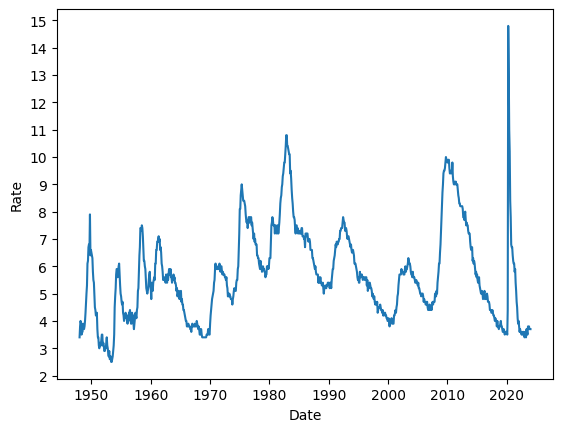

In [93]:
ax = sn.lineplot(df, x='Date', y='Rate')
min_r = int(min(df['Rate']))
max_r = int(max(df['Rate']))
ax.set_yticks(ticks=range(min_r, max_r+2))
plt.show()

In [94]:
df

,Date,Rate
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
908,2023-09-01,3.8
909,2023-10-01,3.8
910,2023-11-01,3.7
911,2023-12-01,3.7


In [130]:
# Read the data
unemp = df.copy()

# Convert DATE column to datetime
# unemp['Date'] = pd.to_datetime(unemp['Date'])

# Sort the DataFrame by DATE
unemp.sort_values(by='Date', inplace=True)

# Generate a data set where data is randomly missing
df_random_miss_idx = np.random.choice(unemp.index, size=int(0.1 * len(unemp)), replace=False)
df_random_miss = unemp.drop(df_random_miss_idx)

# Generate a data set where data is more likely to be missing when unemployment is high
high_unemp_idx = unemp[unemp['Rate'] > 8].index
num_to_select = round(0.2 * len(high_unemp_idx))
high_unemp_idx_sampled = np.random.choice(high_unemp_idx, size=num_to_select, replace=False)
df_random_miss_high = unemp.drop(high_unemp_idx_sampled)

Missing data randomly:

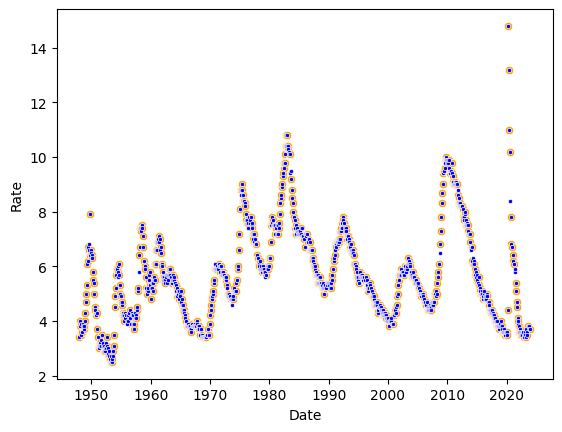

In [101]:
sn.scatterplot(df_random_miss, x='Date', y='Rate', marker='o', color='orange')
sn.scatterplot(df, x='Date', y='Rate', marker='.', color='b')
plt.show()

More likely to miss data when the *Rate* is high:

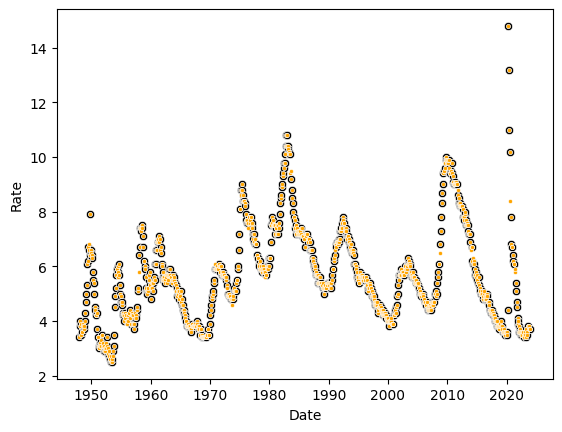

In [102]:
sn.scatterplot(df_random_miss, x='Date', y='Rate', marker='o', color='k')
sn.scatterplot(df, x='Date', y='Rate', marker='.', color='orange')
plt.show()

Creating a range of no-missing dates:

In [129]:
dates_random_miss = pd.date_range(start=df_random_miss.Date.iloc[0], end=df_random_miss.Date.iloc[-1], freq='MS')
dates_random_miss_high = pd.date_range(start=df_random_miss_high.Date.iloc[0], end=df_random_miss.Date.iloc[-1], freq='MS')

Defining *Date* as the index:

In [138]:
df_random_miss.index = df_random_miss['Date']
df_random_miss.drop(columns='Date', inplace=True)

Changing indices to the non-missing range of dates:

In [143]:
df_random_miss_rid = df_random_miss.Rate.reindex(dates_random_miss, fill_value=np.nan)
df_random_miss_high_rid = df_random_miss.Rate.reindex(dates_random_miss_high, fill_value=np.nan)

#### **Forward fill:**

In [149]:
df_random_miss_rid = df_random_miss_rid.ffill().bfill()

In [166]:
df_random_miss_high_rid = df_random_miss_high_rid.ffill().bfill()

In [173]:
print(df_random_miss_rid.shape)
print(df_random_miss_high_rid.shape)
print(df.shape)

(913,)
(913,)
(913, 2)


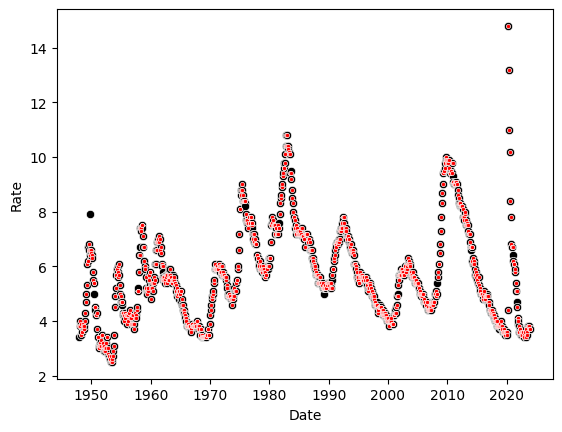

In [174]:
sn.scatterplot(df, x='Date', y='Rate', marker='o', color='k')
sn.scatterplot(x=df_random_miss_rid.index, y=df_random_miss_rid, marker='.', color='r')
plt.show()

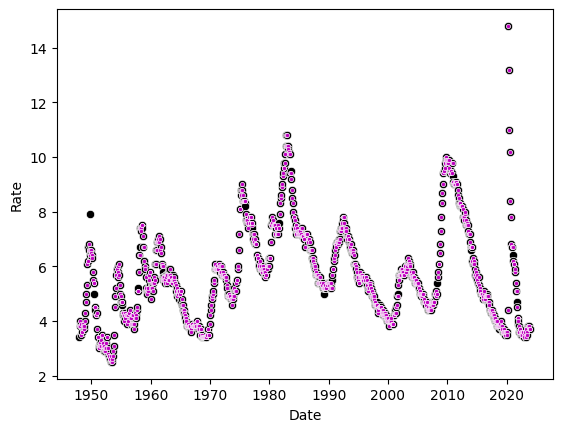

In [175]:
sn.scatterplot(df, x='Date', y='Rate', marker='o', color='k')
sn.scatterplot(x=df_random_miss_high_rid.index, y=df_random_miss_high_rid, marker='.', color='m')
plt.show()

#### **Moving average**: